# Image generation app 🎨

Load your HF API key and relevant Python libraries

In [1]:
!pip install python-dotenv
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [2]:
import os
import io
import IPython.display
from PIL import Image
import base64
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

In [14]:
# Helper function
import requests, json

#Text-to-image endpoint
def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_TTI_BASE']):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    # return json.loads(response.content.decode("utf-8"))
    return response.content

## Building an image generation app

Here we are going to run `runwayml/stable-diffusion-v1-5` using the `🧨 diffusers` library.

### How about running it locally?
The code would look very similar if you were running it locally instead of from an API.
```py
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

def get_completion(prompt):
    return pipeline(prompt).images[0]    
```

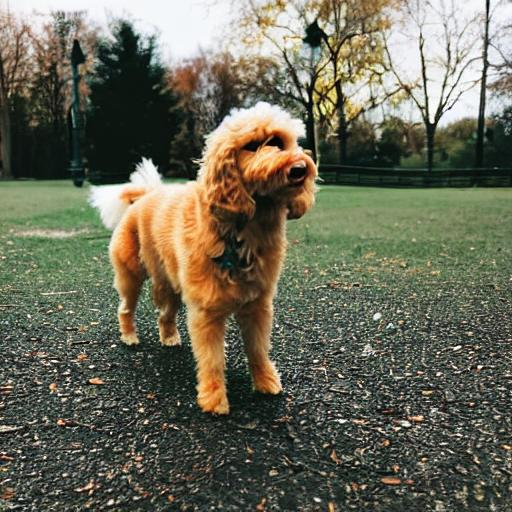

In [18]:
prompt = "a dog in a park"

result = get_completion(prompt)
# IPython.display.HTML(f'<img src="data:image/png;base64,{result}" />')
Image.open(io.BytesIO(result))

## Generating with `gr.Interface()`

In [22]:
import gradio as gr

#A helper function to convert the PIL image to base64
#so you can send it to the API
def base64_to_pil(img_base64):
    # base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(img_base64)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt):
    output = get_completion(prompt)
    result_image = base64_to_pil(output)
    return result_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="Your prompt")],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never",
                    examples=["the spirit of a tamagotchi wandering in the city of Vienna","a mecha robot in a favela"])

demo.launch(share=False, server_port=int(os.environ['PORT1']))

Closing server running on port: 7901
Closing server running on port: 7901
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [23]:
demo.close()

Closing server running on port: 7901


## Building a more advanced interface

In [25]:
import gradio as gr

#A helper function to convert the PIL image to base64
# so you can send it to the API
def base64_to_pil(img_base64):
    # base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(img_base64)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt, negative_prompt, steps, guidance, width, height):
    params = {
        "negative_prompt": negative_prompt,
        "num_inference_steps": steps,
        "guidance_scale": guidance,
        "width": width,
        "height": height
    }

    output = get_completion(prompt, params)
    pil_image = base64_to_pil(output)
    return pil_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[
                        gr.Textbox(label="Your prompt"),
                        gr.Textbox(label="Negative prompt"),
                        gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                                 info="In how many steps will the denoiser denoise the image?"),
                        gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                                  info="Controls how much the text prompt influences the result"),
                        gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512),
                        gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512),
                    ],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never"
                    )

demo.launch(share=True, server_port=int(os.environ['PORT2']))

Closing server running on port: 7901
Closing server running on port: 7901
Closing server running on port: 7901
Closing server running on port: 7902
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ab1aab5667d3a7c9f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [26]:
demo.close()

Closing server running on port: 7902


## `gr.Blocks()` to the rescue!

In [27]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    prompt = gr.Textbox(label="Your prompt")
    with gr.Row():
        with gr.Column():
            negative_prompt = gr.Textbox(label="Negative prompt")
            steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
            guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
            width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
            height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
            btn = gr.Button("Submit")
        with gr.Column():
            output = gr.Image(label="Result")

    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT3']))

Closing server running on port: 7902
Closing server running on port: 7901
Closing server running on port: 7901
Closing server running on port: 7902
Closing server running on port: 7901
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3695ec4850831d77ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [28]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    with gr.Row():
        with gr.Column(scale=4):
            prompt = gr.Textbox(label="Your prompt") #Give prompt some real estate
        with gr.Column(scale=1, min_width=50):
            btn = gr.Button("Submit") #Submit button side by side!
    with gr.Accordion("Advanced options", open=False): #Let's hide the advanced options!
            negative_prompt = gr.Textbox(label="Negative prompt")
            with gr.Row():
                with gr.Column():
                    steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
                    guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
                with gr.Column():
                    width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
                    height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
    output = gr.Image(label="Result") #Move the output up too

    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])

gr.close_all()
demo.launch(share=False, server_port=int(os.environ['PORT4']))

Closing server running on port: 7902
Closing server running on port: 7901
Closing server running on port: 7901
Closing server running on port: 7902
Closing server running on port: 7901
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
#gr.close_all()